In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# border and row shading fro tables
a_color = "saddlebrown"
table_row = "saddlebrown"

## !! Begin Note book variables !!
# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/survey_areas/aare_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'aare', 'name':"Erhebungsgebiet Aare", 'level':'river_bassin'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'water_name_slug'

# identify the lakes of interest for the survey area
lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]

# !! End note book variables !!

## data
# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# code definitions
dxCodes = pd.read_csv("resources/codes_with_group_names")
dxCodes.set_index("code", inplace=True)

# columns that need to be renamed. Setting the language will automatically
# change column names, code descriptions and chart annotations
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# !key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
fdx.codeGroupSummary()
# !this is the feature data!
fd = fdx.feature_data

# !keyword args to build period data
# the period data is all the data that was collected
# during the same period from all the other locations
# not included in the feature data. For a survey area
# or river bassin these_features = feature_paren and 
# feature_level = parent_level
period_kwargs = {
    "period_data": fdx.period_data,
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# the rivers are considered separately
# select only the results from rivers
# this can be done by updating the fd_kwargs
fd_rivers = fd_kwargs.update({"water_type":"r"})
fdr = featuredata.Components(**fd_kwargs)
fdr.makeFeatureData()
fdr.adjustForLanguage()
fdr.makeFeatureData()
fdr.locationSampleTotals()
fdr.makeDailyTotalSummary()
fdr.materialSummary()
fdr.mostCommon()

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    **{"dfBeaches":dfBeaches}
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()

# update the admin kwargs with river data to make the river summary
admin_kwargs.update({"data":fdr.feature_data})
admin_r_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_r_summary = admin_r_details.summaryObject()

(aaresa)=
# Aare

In [2]:
map_caption = [
    "Karte des Erhebungsgebiets März 2020 bis Mai 2021. ",
    "Der Durchmesser der Punktsymbole entspricht dem Median der",
    "Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort."
]

```{figure} resources/maps/survey_areas/aare_scaled.jpeg
---
name: aare_survey_area_map
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_map>` Karte des Erhebungsgebiets März 2020 bis Mai 2021. Der Durchmesser der Punktsymbole entspricht dem Median der Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort.  

## Erhebungsorte und Landnutzungsprofile

In [3]:
rivers = admin_details.riversOfInterest()
lakes = admin_details.lakesOfInterest()
        
# string objects for display
obj_string = featuredata.thousandsSeparator(admin_summary["quantity"], language)
surv_string = "{:,}".format(admin_summary["loc_date"])
pop_string = featuredata.thousandsSeparator(int(admin_summary["population"]), language)

# make strings
date_quantity_context = F"Im Zeitraum von {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)}  bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= date_lang)} wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {this_feature['name']} umfassen {admin_summary['location']} Orte, {admin_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnenden."

# lists of landmarks of interest
munis_joined = ", ".join(sorted(admin_details.populationKeys()["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Seen:*\n\n>{lakes_joined}

*Fliessgewässer:*\n\n>{rivers_joined}

*Gemeinden:*\n\n>{munis_joined}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 140 Datenerhebungen insgesamt 13 847 Objekte entfernt und identifiziert. Die Ergebnisse des Erhebungsgebiet Aare umfassen 51 Orte, 35 Gemeinden und eine Gesamtbevölkerung von etwa 493 799 Einwohnenden.

*Seen:*

>Bielersee, Brienzersee, Neuenburgersee, Thunersee

*Fliessgewässer:*

>Aare, Emme, La Thièle, Nidau-Büren-Kanal, Schüss

*Gemeinden:*

>Aarau, Beatenberg, Bern, Biel/Bienne, Boudry, Brienz (BE), Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Erlach, Estavayer, Gals, Gebenstorf, Grandson, Hauterive (NE), Kallnach, Köniz, Le Landeron, Ligerz, Luterbach, Lüscherz, Neuchâtel, Nidau, Port, Rubigen, Solothurn, Spiez, Thun, Unterseen, Vinelz, Walperswil, Yverdon-les-Bains


### Landnutzungsprofil der Erhebungsorte

Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von den folgenden vier Kategorien zugewiesen:

* Fläche, die von Gebäuden eingenommen wird in %
* Fläche, die dem Wald vorbehalten ist in %
* Fläche, die für Aktivitäten im Freien genutzt wird in %
* Fläche, die von der Landwirtschaft genutzt wird in %

Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer innerhalb eines Radius von 1500 m angegeben.

Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von 1500 m um den Erhebungsort herum in das Gewässer münden.

Das Verhältnis der gefundenen Abfallobjekte unterscheidet sich je nach Landnutzungsprofil. Das Verhältnis gibt daher einen Hinweis auf die ökologischen und wirtschaftlichen Bedingungen um den Erhebungsort.

Für weitere Informationen siehe *[17 Landnutzungsprofil](luseprofile)*

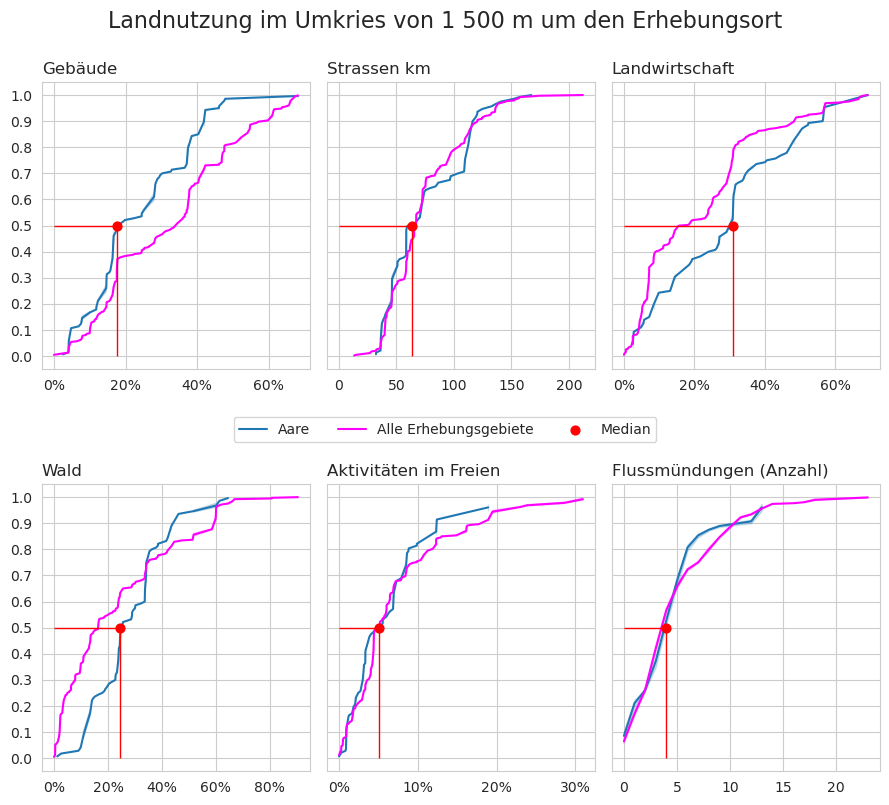

In [4]:
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level']   
}

project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()
land_use_kwargs.update({"data":fdx.feature_data})
feature_profile = featuredata.LandUseProfile(**land_use_kwargs)
feature_landuse = feature_profile.featureOfInterest()

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")
from matplotlib.ticker import MultipleLocator
for i, n in enumerate(featuredata.default_land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]
    
    for element in feature_landuse:
        data = element[n].values
        element_name = element[feature_profile.feature_level].unique()
        label = featuredata.river_basin_de[element_name[0]]
        
        xs, ys = featuredata.empiricalCDF(data) 
        sns.lineplot(x=xs, y=ys, ax=ax, label=label)
    
    # the value of the land use feature n for all the data
    testx, testy = featuredata.empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label=top, color="magenta")
    
    # get the median from the data
    the_median = np.median(data)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=40, linewidth=1, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=1)
    
    if i <= 3:
        if c == 0:            
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_title(featuredata.luse_de[n], loc='left')
    
plt.tight_layout()
plt.subplots_adjust(top=.91, hspace=.4)
plt.suptitle("Landnutzung im Umkries von 1 500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.5), loc="upper center", ncol=3) 

glue("aare_survey_area_landuse", fig, display=False)

plt.close()

```{glue:figure} aare_survey_area_landuse
---
name: 'aare_survey_area_landuse'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_landuse>` Landnutzungsprofil der Erhebungsorte. Verteilung der Erhebungen in Bezug auf die Landnutzung. LWS = Landwirtschaft

### Kumulative Gesamtmengen nach Gewässer

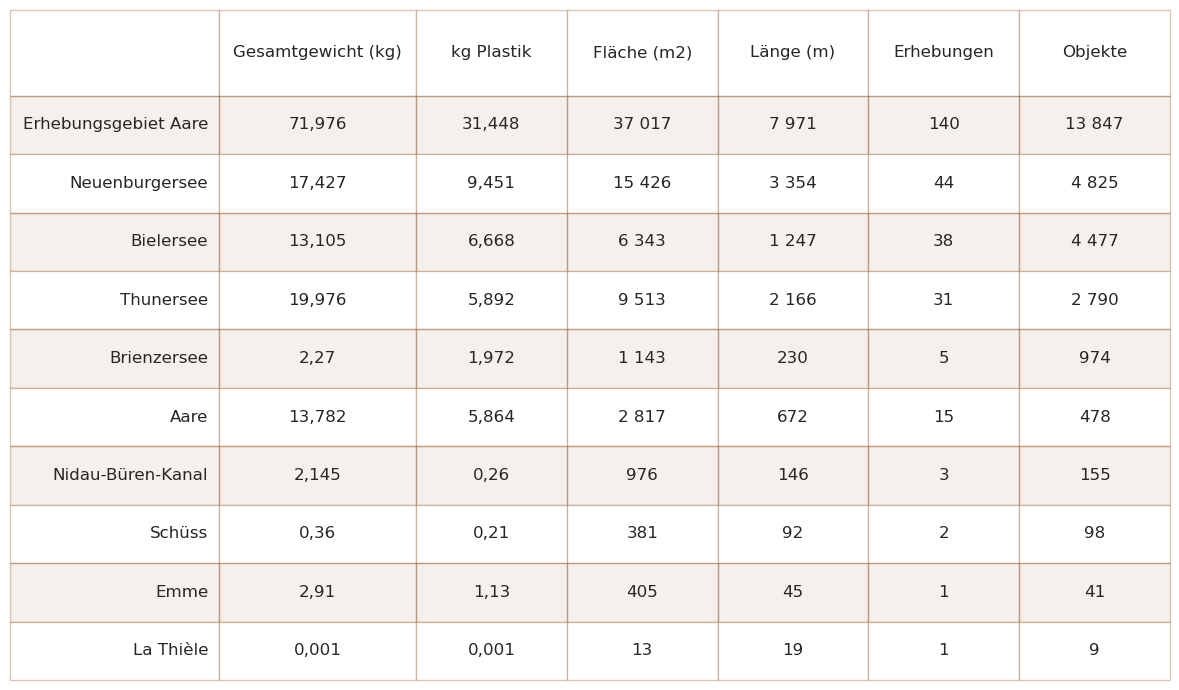

In [5]:
# the dimensional data
dims_table = admin_details.dimensionalSummary()
# a method to update the place names from slug to proper name
name_map = admin_details.makeFeatureNameMap()

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
# translating column names
dims_table.rename(columns=featuredata.dims_table_columns_de, inplace=True)

# the values in these columns need formating to swiss spec
thousands_separated = ["Fläche (m2)", "Länge (m)", "Erhebungen", "Objekte"]
replace_decimal = ["kg Plastik", "Gesamtgewicht (kg)"]

dims_table["kg Plastik"] = dims_table["kg Plastik"]/1000
dims_table[thousands_separated] = dims_table[thousands_separated].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
dims_table[replace_decimal] = dims_table[replace_decimal].applymap(lambda x: featuredata.replaceDecimal(str(round(x,3))))

data = dims_table.reset_index()
# replace the data slugs with the appropriate name
data["water_name_slug"] = data.water_name_slug.map(lambda x: featuredata.updatePlaceNames(x=x, a_map=name_map))

colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*1.7,len(data)*.7))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, colWidths=[.18, .17, *[.13]*5], a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")
table_one.set_fontsize(12)

plt.tight_layout()
glue("aare_survey_area_dimensional_summary", fig, display=False)
plt.close()


```{glue:figure} aare_survey_area_dimensional_summary
---
name: 'aare_survey_area_dimensional_summary'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_dimensional_summary>` Die kumulierten Gewichte und Merkmale für das Erhebungsgebiet Aare nach Gewässern.

### Verteilung der Erhebungsergebnisse

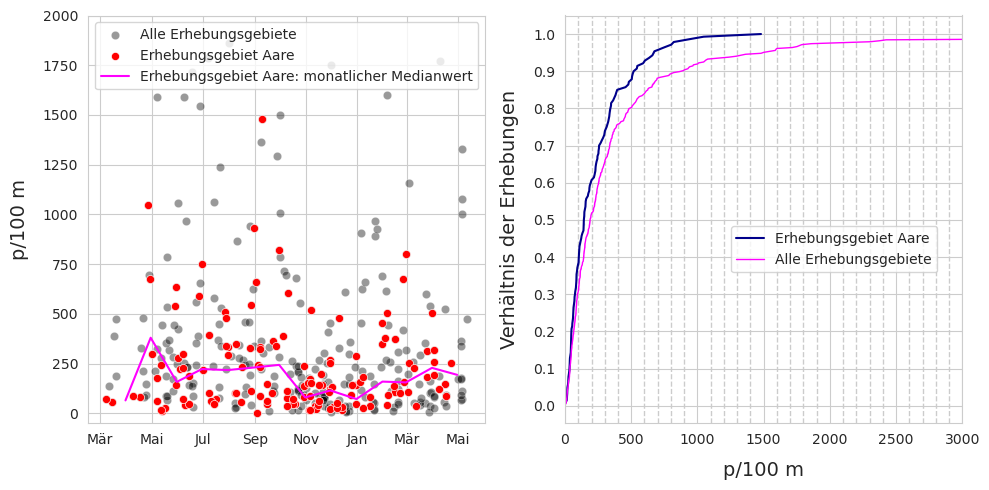

In [6]:
dx = period_data.parentSampleTotals(parent=False)

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# get the monthly or quarterly results for the feature
rsmp = fdx.sample_totals.set_index("date")
resample_plot, rate = featuredata.quarterlyOrMonthlyValues(rsmp, this_feature["name"], vals=unit_label)

fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]

# feature surveys
sns.scatterplot(data=dx, x="date", y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fdx.sample_totals, x="date", y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)
# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

y_lim = 95
y_limit = np.percentile(dx[unit_label], y_lim)
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
# ax.margins(x=.05, y=.05)
ax.set_ylim(-50, 2000)

ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = featuredata.ecdfOfAColumn(fdx.sample_totals, unit_label)    
sns.lineplot(x=feature_ecd["x"], y=feature_ecd["y"], color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = featuredata.ecdfOfAColumn(dx, unit_label)
sns.lineplot(x=other_features["x"], y=other_features["y"], color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)
axtwo.set_xlim(0, 3000)
axtwo.legend(bbox_to_anchor=(.4,.5), loc="upper left")
axtwo.xaxis.set_major_locator(MultipleLocator(500))
axtwo.xaxis.set_minor_locator(MultipleLocator(100))
axtwo.yaxis.set_major_locator(MultipleLocator(.1))
axtwo.grid(which="minor", visible=True, axis="x", linestyle="--", linewidth=1)

plt.tight_layout()
glue("aare_survey_area_sample_totals", fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_sample_totals
---
name: 'aare_survey_area_sample_totals'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_sample_totals>` __Links:__ Erhebungsgebiet Aare, März 2020 bis Mai 2021, n = 140. Werte grösser als 1 766 p/100 m werden nicht gezeigt. __Rechts:__ empirische Verteilungsfunktion im Erhebungsgebiet Aare.

### Zusammengefasste Daten und Materialarten

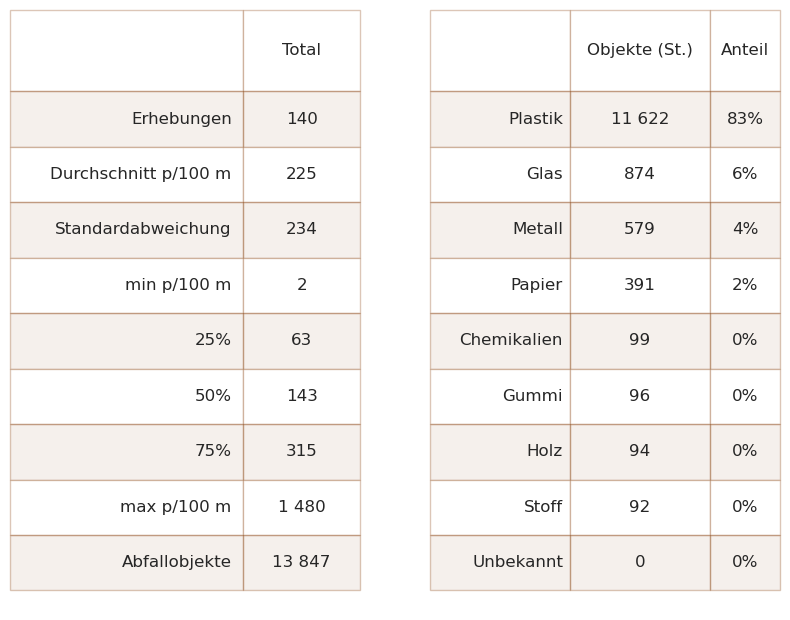

In [28]:
csx = fdx.sample_summary.copy()


combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]


# the materials table
fd_mat_totals = fdx.material_summary.copy()
fd_mat_totals = featuredata.fmtPctOfTotal(fd_mat_totals, around=0)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Objekte (St.)", "% of total":"Anteil"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], featuredata.thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,len(combined_summary)*.7))

# summary table
# names for the table columns
a_col = [this_feature["name"], "Total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(12)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .4,.2],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
glue('aare_survey_area_sample_material_tables', fig, display=False)
plt.close()

{numref}`Abbildung %s: <aare_survey_area_sample_material_tables>` __Links__: Zusammenfassung der Daten aller Erhebungen Erhebungsgebiet Aare. __Rechts:__ Gefundene Materialarten im Erhebungsgebiet Aare in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).

```{glue:figure} aare_survey_area_sample_material_tables
---
name: 'aare_survey_area_sample_material_tables'
---
` `
```

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate)

In [8]:
# get percent of total
m_common_percent_of_total = fdx.most_common["quantity"].sum()/fdx.code_summary["quantity"].sum()

rb_string = f"""
*__Unten__: Häufigste Objekte im {this_feature['name']}: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*
"""
md(rb_string)


*__Unten__: Häufigste Objekte im Erhebungsgebiet Aare: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte 67% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*


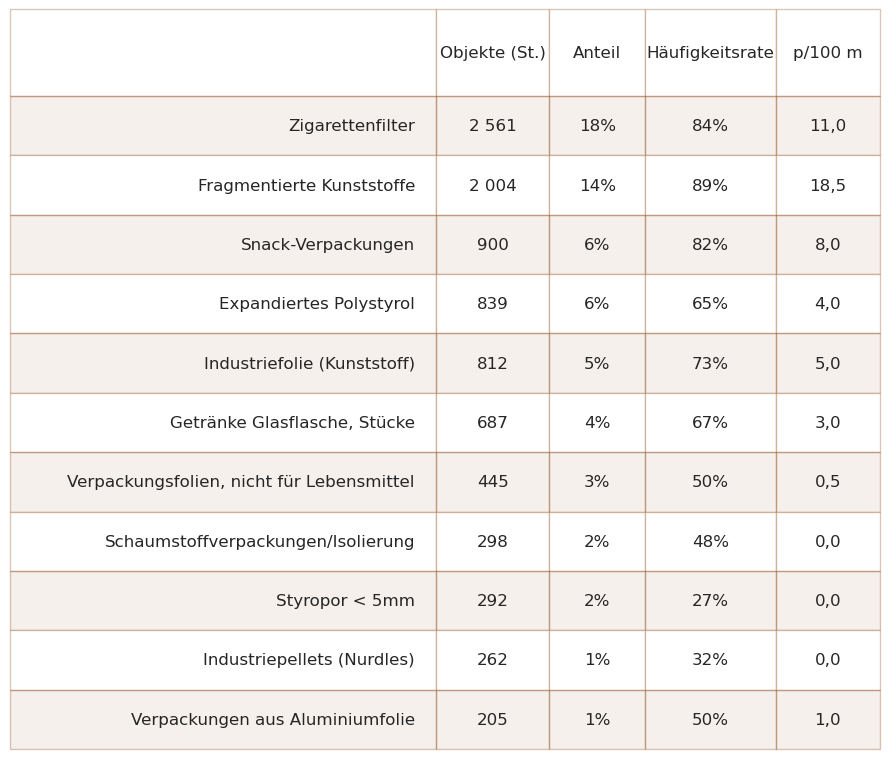

In [9]:
# format values for table
m_common = fdx.most_common.copy()
m_common["item"] = m_common.index.map(lambda x: fdx.dMap.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{int(x)}%")
m_common["quantity"] = m_common.quantity.map(lambda x:featuredata.thousandsSeparator(x, language))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# format the table headers
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(9,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.49, .13,.11,.15, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
glue('aare_survey_area_most_common_tables', fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_most_common_tables
---
name: 'aare_survey_area_most_common_tables'
---
` `
```

### Die am häufigsten gefundenen Objekte nach Gewässer

In [10]:
rb_string = F"""
*__Unten:__ Median (p/100 m) der häufigsten Objekte im {this_feature["name"]}.*
"""
# md(rb_string)

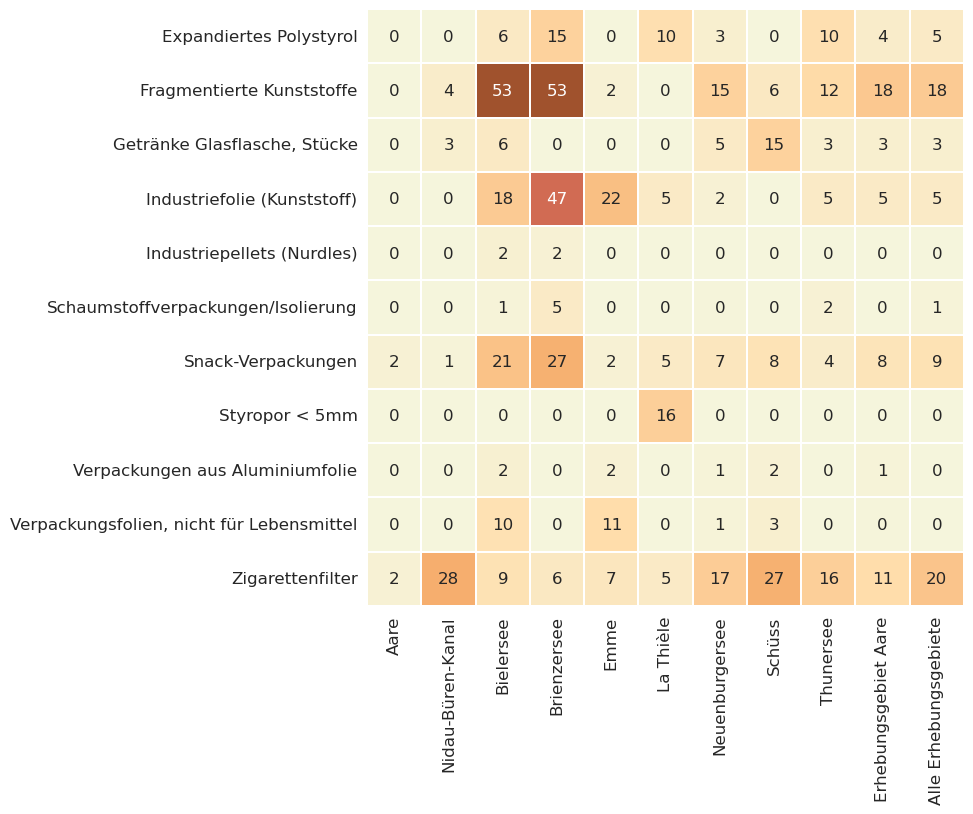

In [11]:
# map to proper names for features
feature_names = admin_details.makeFeatureNameMap()

components = fdx.componentMostCommonPcsM()

# pivot that
mc_comp = components[["item", unit_label, "water_name_slug"]].pivot(columns="water_name_slug", index="item")

# quash the hierarchal column index
mc_comp.columns = mc_comp.columns.get_level_values(1)

proper_column_names = {x : feature_names.loc[x, 'water_name'] for x in mc_comp.columns}
mc_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the survey area
mc_feature = fdx.most_common[unit_label]
mc_feature = featuredata.changeSeriesIndexLabels(mc_feature, {x:fdx.dMap.loc[x] for x in mc_feature.index})

# the aggregated totals of all the data
mc_period = period_data.parentMostCommon(parent=False)
mc_period = featuredata.changeSeriesIndexLabels(mc_period, {x:fdx.dMap.loc[x] for x in mc_period.index})

mc_comp[this_feature["name"]]= mc_feature
mc_comp[top] = mc_period

# chart that
fig, ax  = plt.subplots(figsize=(len(mc_comp.columns)*.7,len(mc_comp)*.8))

sns.heatmap(mc_comp, ax=ax, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", square=True, cbar=False, linewidth=.1, linecolor="white")
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both")

plt.setp(ax.get_xticklabels(), rotation=90)

glue('aare_survey_area_most_common_heat_map', fig, display=False)
plt.close()

{numref}`Abbildung %s: <aare_survey_area_most_common_heat_map>` Median (p/100 m) der häufigsten Objekte im Erhebungsgebiet Aare.

```{glue:figure} aare_survey_area_most_common_heat_map
---
name: 'aare_survey_area_most_common_heat_map'
---
` `
```

### Die am häufigsten gefundenen Objekte im monatlichen Durchschnitt

In [12]:
monthly_mc = F"""
*__Below:__ {this_feature["name"]}, monatliche Durchschnittsergebnisse p/100 m.*
"""
# md(monthly_mc)

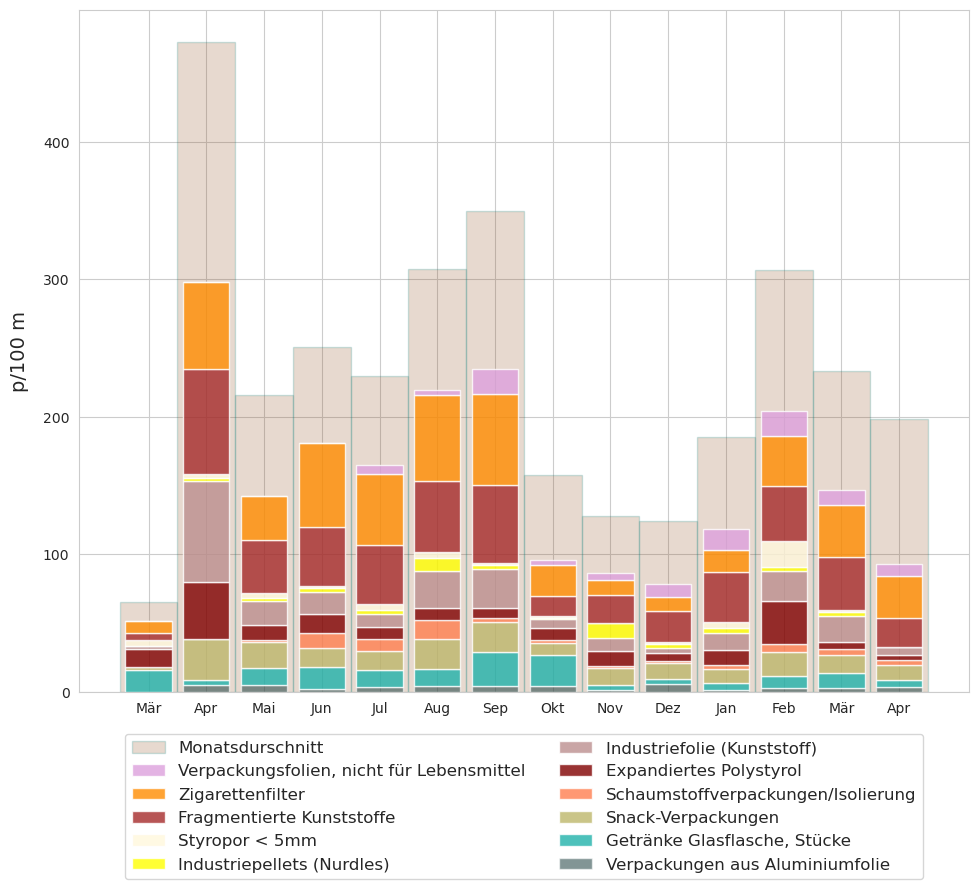

In [13]:
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(10,9))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=table_row, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [sut.months_de[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [fdx.dMap.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monatsdurschnitt")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=12)
plt.tight_layout()
glue("aare_survey_area_monthly_results", fig, display=False)
plt.close()

{numref}`Abbildung %s: <aare_survey_area_monthly_results>` Erhebungsgebiet Aare, monatliche Durchschnittsergebnisse p/100 m.

```{glue:figure} aare_survey_area_monthly_results
---
name: 'aare_survey_area_monthly_results'
---
` `
```

## Erhebungsergebnisse und Landnutzung

Das Landnutzungsprofil ist eine Darstellung der Art und des Umfangs der wirtschaftlichen Aktivität und der Umweltbedingungen rund um den Erhebungsort. Die Schlüsselindikatoren aus den Ergebnissen der Datenerhebungen werden mit dem Landnutzungsprofil für einen Radius von 1500 m um den Erhebungsort verglichen.

Eine Assoziation ist eine Beziehung zwischen den Ergebnissen der Datenerhebungen und dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist weder definiert noch linear.

Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein statistisch signifikanter Zusammenhang zwischen der Landnutzung und den bei einer Abfallobjekte-Erhebung identifizierten Objekten besteht.

Die verwendete Methode ist der Spearmans Rho oder Spearmans geordneter Korrelationskoeffizient. Die Testergebnisse werden bei p < 0,05 für alle gültigen Erhebungen an Seen im Untersuchungsgebiet ausgewertet.

1. Rot/Rosa steht für eine positive Assoziation
2. Gelb steht für eine negative Assoziation
3. Weiss bedeutet, dass keine statistische Grundlage für die Annahme eines Zusammenhangs besteht

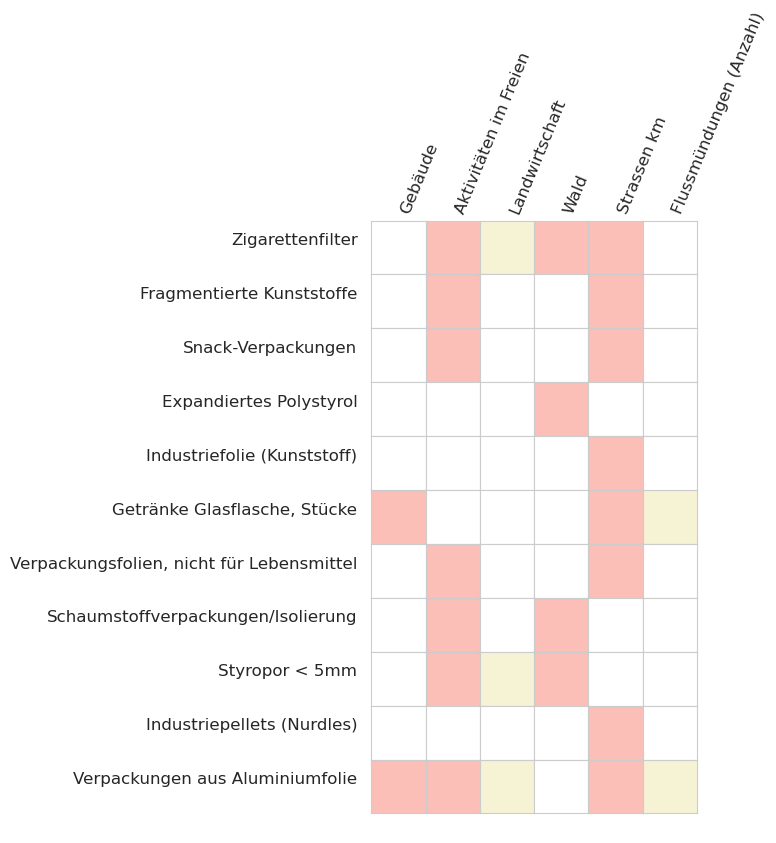

In [14]:
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_of_interest))].copy()
land_use_columns = featuredata.default_land_use_columns
code_description_map = fdx.dMap

def make_plot_with_spearmans(data, ax, n, unit_label="p/100m"):
    """Gets Spearmans ranked correlation and make A/B scatter plot. Must proived a
    matplotlib axis object.
    """
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    
    if a_p < 0.05:
        if corr > 0:
            ax.patch.set_facecolor("salmon")
            ax.patch.set_alpha(0.5)
        else:
            ax.patch.set_facecolor("palegoldenrod")
            ax.patch.set_alpha(0.5)

    return ax, corr, a_p

# chart the results of test for association
fig, axs = plt.subplots(len(m_common.index),len(land_use_columns), figsize=(len(land_use_columns)*.7,len(m_common.index)*.7), sharey="row")

# the test is conducted on the survey results for each code
for i,code in enumerate(m_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(land_use_columns):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(f"{featuredata.luse_de[n]}", rotation=67.5, ha="left", fontsize=12)
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(f"{code_description_map[code]}", rotation=0, ha="right", labelpad=10, fontsize=12)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        ax = make_plot_with_spearmans(data, ax, n, unit_label=unit_label)
        
plt.subplots_adjust(wspace=0, hspace=0)
glue('aare_survey_area_spearmans', fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_spearmans
---
name: 'aare_survey_area_spearmans'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_spearmans>` Ausgewertete Korrelationen der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil im Erhebungsgebiet Aare. Für alle gültigen Erhebungen an Seen n = 118. *__Legende:__ wenn p > 0,05 = weiss, wenn p < 0,05 und Rho > 0 = rot, wenn p < 0,05 und Rho < 0 = gelb*

## Verwendungszweck der gefundenen Objekte

Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe.

In [15]:
cg_poft = F"""
__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gewässer im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.
"""
# md(cg_poft)

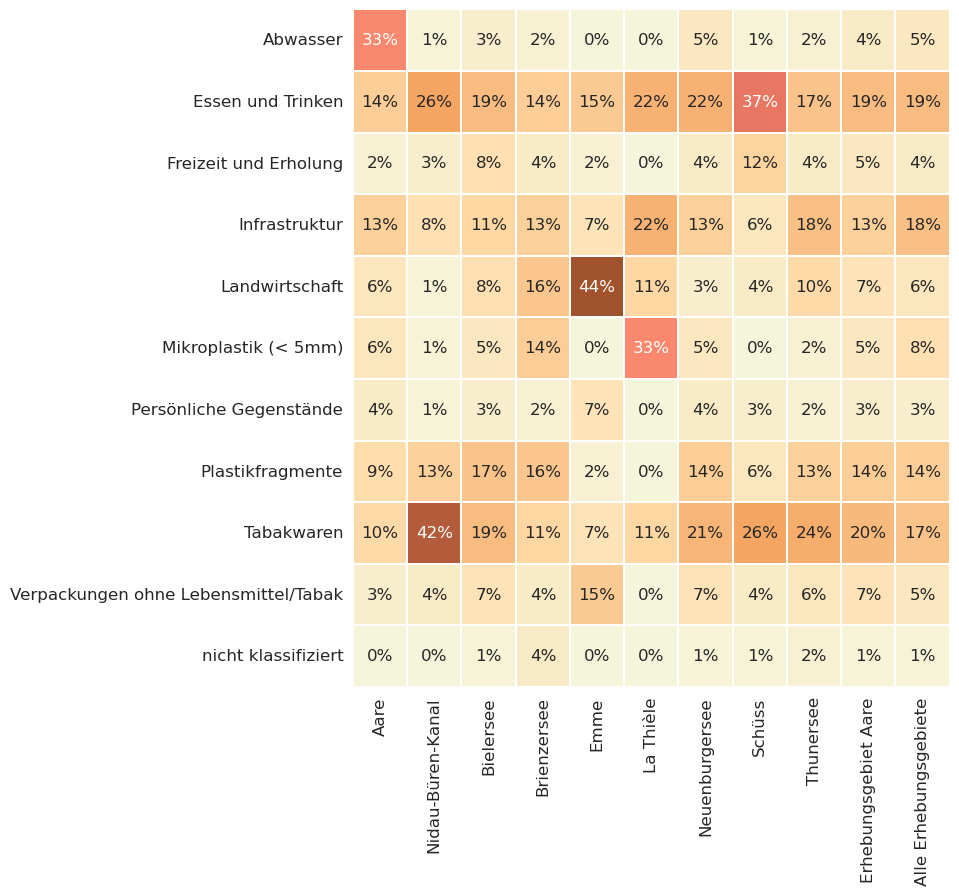

In [16]:
components = fdx.componentCodeGroupResults()

# pivot that
pt_comp = components[["water_name_slug", "groupname", '% of total' ]].pivot(columns="water_name_slug", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = proper_column_names, inplace=True)

# the aggregated totals for the parent level
pt_parent = period_data.parentGroupTotals(parent=True, percent=True)
pt_comp[this_feature["name"]] = pt_parent

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=True)
pt_comp[top] = pt_period

# make figure
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

sns.heatmap(pt_comp , ax=ax, cmap=cmap2, annot=True,  annot_kws={"fontsize":12}, fmt=".0%", cbar=False, linewidth=.1, linecolor="white")

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.setp(ax.get_yticklabels(), rotation=0)

glue('aare_survey_area_codegroup_percent', fig, display=False)

plt.close()

```{glue:figure} aare_survey_area_codegroup_percent
---
name: 'aare_survey_area_codegroup_percent'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_codegroup_percent>` Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gewässer im Erhebungsgebiet Aare. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.

In [17]:
cg_medpcm = F"""
<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median p/100 m im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
# md(cg_medpcm)

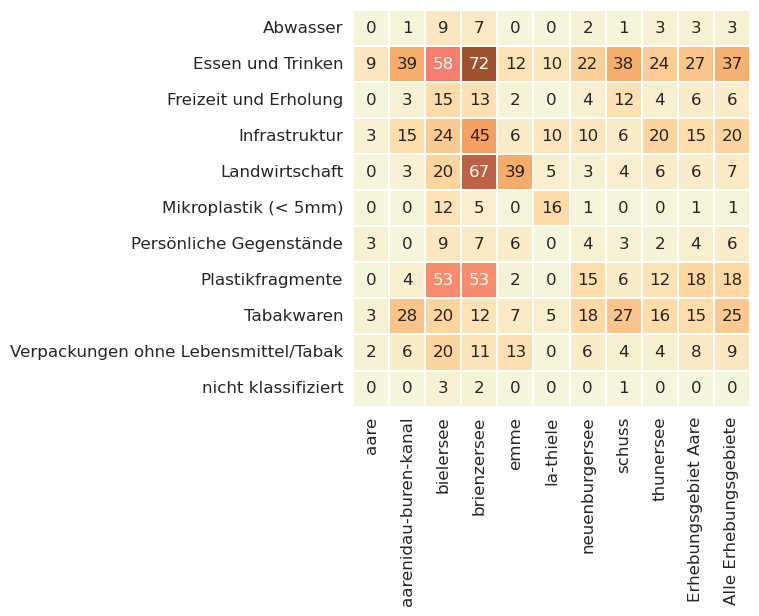

In [18]:
# pivot that
grouppcs_comp = components[["water_name_slug", "groupname", unit_label ]].pivot(columns="water_name_slug", index="groupname")

# quash the hierarchal column index
grouppcs_comp.columns = grouppcs_comp.columns.get_level_values(1)

# the aggregated codegroup results from the feature
pt_feature = fdx.codegroup_summary[unit_label]
grouppcs_comp[this_feature["name"]] = pt_feature

# the aggregated totals for the parent level
pt_parent = period_data.parentGroupTotals(parent=True, percent=False)
grouppcs_comp[this_feature["name"]] = pt_parent

# the aggregated totals for the period
pt_period = period_data.parentGroupTotals(parent=False, percent=False)
grouppcs_comp[top] = pt_period


# make figure
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

sns.heatmap(grouppcs_comp, ax=ax, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", cbar=False, linewidth=.1, square=True, linecolor="white")

ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params(labelsize=12, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.setp(ax.get_yticklabels(), rotation=0)
plt.tight_layout()

glue("aare_survey_area_codegroup_pcsm", fig, display=False)

plt.close()

```{glue:figure} aare_survey_area_codegroup_pcsm
---
name: 'aare_survey_area_codegroup_pcsm'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_codegroup_pcsm>` Verwendungszweck der gefundenen Objekte Median p/100 m im Erhebungsgebiet Aare. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.

## Fliessgewässer

In [19]:
rivers = fdr.sample_totals
lakes = fdx.sample_totals

chart_notes = F"""
*__Left:__ {this_feature["name"]} Fliessgewässer, {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)} bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang=date_lang)}, n = {len(rivers.loc_date.unique())}. __Rechts:__ Zusammenfassung der Daten.*
"""
# md(chart_notes )

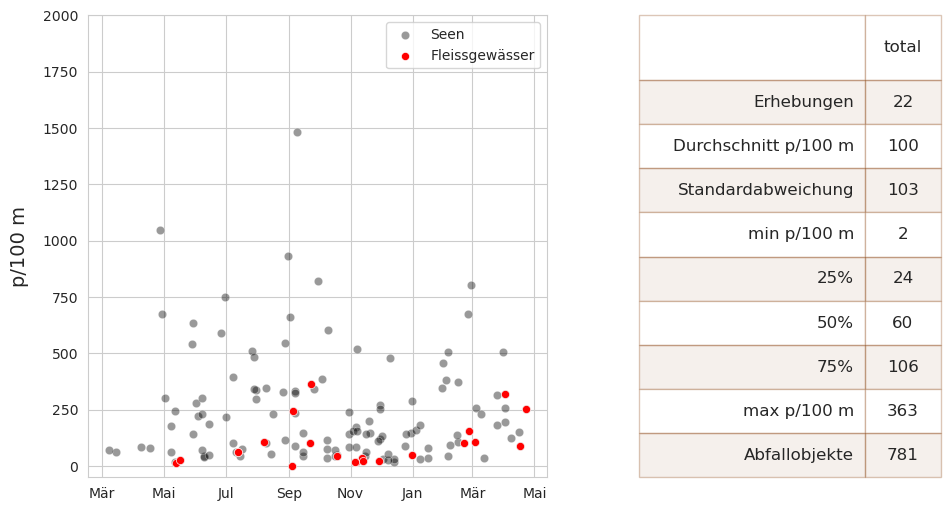

In [20]:
# summary of sample totals
csx = fdr.sample_summary.copy()
combined_summary =[(x, featuredata.thousandsSeparator(int(csx[x]), language)) for x in csx.index]

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=lakes, x="date", y=unit_label, color="black", alpha=0.4, label="Seen", ax=ax)
sns.scatterplot(data=rivers, x="date", y=unit_label, color="red", s=34, ec="white",label="Fleissgewässer", ax=ax)

ax.set_ylabel(unit_label, labelpad=10, fontsize=14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
# ax.margins(x=.05, y=.05)
ax.set_ylim(-50, 2000)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 7:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")

glue('aare_survey_area_rivers_summary', fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_rivers_summary
---
name: 'aare_survey_area_rivers_summary'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_rivers_summary>` __Links:__ Erhebungsgebiet Aare Fliessgewässer, März 2020 bis Mai 2021, n = 22. Werte grösser als 1 766 p/100 m werden nicht gezeigt. __Rechts:__ Zusammenfassung der Daten.


### Die an Fliessgewässern am häufigsten gefundenen Objekte

In [21]:
riv_mcommon = F"""
*__Below:__ Häufigste Objekte p/100 m an Fliessgewässern im {this_feature["name"]}: Medianwert der Erhebung.*
"""
# md(riv_mcommon)

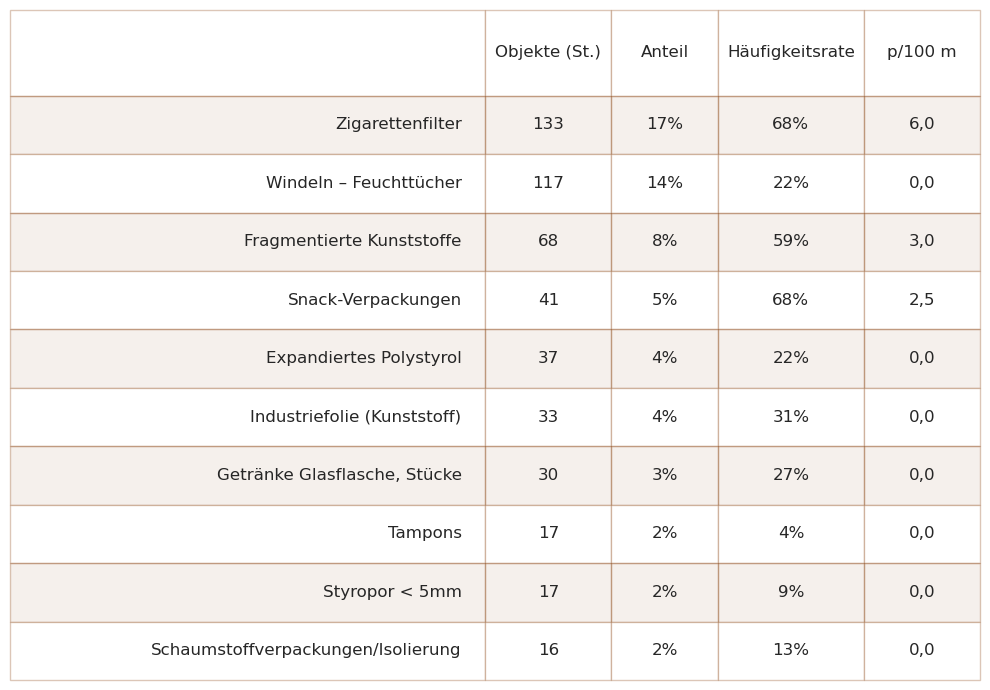

In [22]:
# format values for table
m_common = fdr.most_common.copy()
m_common["item"] = m_common.index.map(lambda x: fdx.dMap.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{int(x)}%")
m_common["quantity"] = m_common.quantity.map(lambda x:featuredata.thousandsSeparator(x, language))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# format the table headers
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.49, .13,.11,.15, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
glue('aare_survey_area_rivers_most_common', fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_rivers_most_common
---
name: 'aare_survey_area_rivers_most_common'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_rivers_most_common>` Häufigste Objekte p/100 m an Fliessgewässern im Erhebungsgebiet Aare: Medianwert der Erhebung.

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [23]:
frag_foams = F"""
*__Below:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im {this_feature["name"]},  Median p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.*
"""
# md(frag_foams)

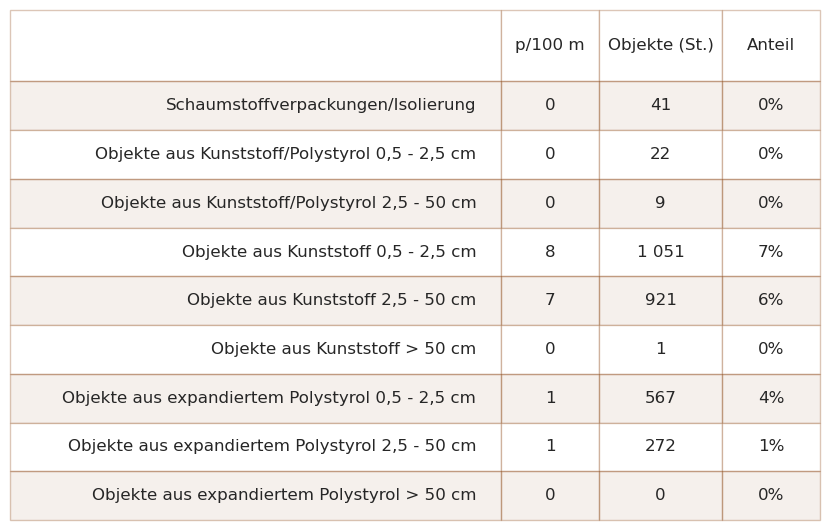

In [27]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)


# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(admin_summary["locations_of_interest"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{int(x)}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
fd_frags_foams[unit_label] = fd_frags_foams[unit_label].astype(int)

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"quantity":"Objekte (St.)", "% of total":"Anteil"}, inplace=True)

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.6))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .12, .15, .12], a_color=table_row)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(12)


plt.tight_layout()
glue('aare_survey_area_fragmented_plastics', fig, display=False)
plt.close()

```{glue:figure} aare_survey_area_fragmented_plastics
---
name: 'aare_survey_area_fragmented_plastics'
---
` `
```
{numref}`Abbildung %s: <aare_survey_area_fragmented_plastics>`  Fragmentierte und geschäumte Kunststoffe nach Grösse im Erhebungsgebiet Aare, Median p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.

### Die Erhebungsorte

In [25]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[admin_summary["locations_of_interest"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)
disp_beaches.set_index("standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,stat
standort,,,
aare-port,47.116170,7.269550,Port
schutzenmatte,47.057666,7.634001,Burgdorf
la-petite-plage,46.785054,6.656877,Yverdon-les-Bains
weissenau-neuhaus,46.676583,7.817528,Unterseen
evole-plage,46.989477,6.923920,Neuchâtel
oberi-chlihochstetten,46.896025,7.532114,Rubigen
plage-de-serriere,46.984850,6.913450,Neuchâtel
mullermatte,47.133339,7.227907,Biel/Bienne
bielersee_vinelz_fankhausers,47.038398,7.108311,Vinelz


### Inventar der Objekte

In [26]:
pd.set_option("display.max_rows", None)
complete_inventory = fdx.code_summary.copy()
complete_inventory["quantity"] = complete_inventory["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
complete_inventory["% of total"] = complete_inventory["% of total"].astype(int)
complete_inventory[unit_label] = complete_inventory[unit_label].astype(int)
complete_inventory.rename(columns=featuredata.inventory_table_de, inplace=True)
complete_inventory.sort_values(by="Objekte (St.)", ascending=False)

,Objekte,Objekte (St.),Anteil,p/100 m,Häufigkeitsrate,Material
code,,,,,,
G21,"Getränke-Deckel, Getränkeverschluss",98,0,0,31,Plastik
G213,Paraffinwachs,98,0,0,18,Chemikalien
G50,Schnur < 1cm,96,0,0,36,Plastik
G23,unidentifizierte Deckel,93,0,0,30,Plastik
G30,Snack-Verpackungen,900,6,8,82,Plastik
G2,"Säcke, Taschen",9,0,0,3,Plastik
G65,Eimer,9,0,0,2,Plastik
G155,Feuerwerkspapierhülsen und -fragmente,9,0,0,6,Papier
G921,Keramikfliesen und Bruchstücke,9,0,0,6,Glas
